In [1]:
import tensorflow as tf
import os.path
from glob import glob
from tqdm import tqdm
import scipy.misc
import random
import time


import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import numpy as np
import sys

#sys.path.append('vgg16-transfer-learning')
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = True


In [2]:
# load categories
with open('categories.txt') as f:
    cont = f.readlines()

cats = [x for x in cont]
print(len(cats))
print(cats[0])

# load labels
truth_text = dict()
truth_idx = dict()
import csv
with open('training_ground_truth.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)  # skip the headers
    for row in reader:
        truth_text[row[0]]=cats[int(row[1])-1]
        truth_idx[row[0]]=int(row[1])-1
        
data_folder = 'training'
image_paths = glob(os.path.join(data_folder, 'training_*.jpg'))
image_shape = (224,224)

print('number of samples', len(image_paths))
print(set(truth_idx.values()))

200
person, individual, someone, somebody, mortal, soul

number of samples 80000
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}


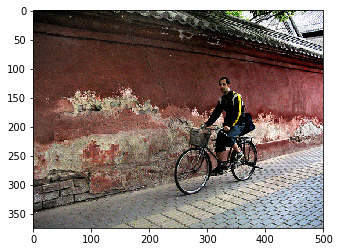

training_29919.jpg truth: bicycle, bike, wheel, cycle
 34
training/training_29919.jpg training_29919.jpg


In [3]:
num = random.randint(1,len(image_paths)+1)
img_label = 'training_' + str(num).zfill(5) + '.jpg'
img_path = 'training/'+img_label
img=mpimg.imread(img_path)
plt.imshow(img)
plt.show()
print(img_label, 'truth:', truth_text[img_label], truth_idx[img_label])
print(img_path,os.path.basename(img_path))

In [ ]:
def get_batches_fn(batch_size):
    """
    Create batches of training data
    :param batch_size: Batch Size
    :return: Batches of training data
    """
    data_folder = 'training'
    image_paths = glob(os.path.join(data_folder, 'training_*.jpg'))
    image_shape = (224,224)

    #print(len(image_paths))
    random.shuffle(image_paths)
    for batch_i in range(0, len(image_paths), batch_size):
        images = []
        gt = []
        for image_file in image_paths[batch_i:batch_i+batch_size]:
            try:
                gt_this = truth_idx[os.path.basename(image_file)]
                img_k = tf.keras.preprocessing.image.load_img(image_file, target_size=image_shape)
                img_r = tf.keras.preprocessing.image.img_to_array(img_k)
                img_r = tf.keras.applications.vgg16.preprocess_input(img_r)
            except:
                continue
            
            images.append(img_r)
            gt.append(gt_this)
        gt_np = np.array(gt)#,dtype = np.int
        im_np = np.array(images) # ,dtype=np.float32
        yield im_np, gt_np
        
def get_accuracy_of_batch(y,prob):
    y_net = np.argmax(prob,axis=1)
    max_probx = np.max(prob[:10],axis=1)
    num = y_net.shape[0]
    matches = (y_net == y)
    #print(y_net[:10], y[:10],max_probx)
    acc = np.sum(matches)/num;
    return acc

In [ ]:
epochs = 50
batch_size = 100
tf.reset_default_graph()

#saver = tf.train.Saver()
nm = "ckps/model_v1"

with tf.Session(config=config) as sess:
    saver = tf.train.import_meta_graph('ckps/model_v1-225.meta')
    saver.restore(sess,'ckps/model_v1-225')
    
    graph = tf.get_default_graph()
    print(graph.get_all_collection_keys())
    #print(tf.get_collection('variables'))
    fc8 = graph.get_tensor_by_name('I_want_to_train_only_these/fc8/BiasAdd:0')
    one_hot_y = graph.get_tensor_by_name("Optimise/onehot_output:0")
    
    
    loss = tf.losses.softmax_cross_entropy(one_hot_y, fc8)
    #loss = graph.get_tensor_by_name("Optimise/softmax_cross_entropy_loss:0")
    prob = graph.get_tensor_by_name("prob:0")
    training_operation = tf.get_collection("train_op")[0]
    input1 = graph.get_tensor_by_name("input_1:0")
    label = graph.get_tensor_by_name("Optimise/label:0")
    
    merged = tf.summary.merge_all()
    #sess.run(tf.variables_initializer(updatable_variables+opt_vars))
    writer = tf.summary.FileWriter('./TFlog2', tf.get_default_graph())
    target = [training_operation, loss,merged,prob] # , merged ,deb_image
    
    t = time.time()
    idx = 0
    for ep in range(epochs):#tqdm(range(epochs))
        batch_index = 0
        for batch_x, batch_y in get_batches_fn(batch_size):
            batch_index += 1
            feed_dict = {input1: batch_x, label: batch_y}
            out = sess.run(target, feed_dict = feed_dict)
            acc = get_accuracy_of_batch(batch_y,out[3])
            writer.add_summary(out[2],idx)
            idx = idx + 1
            elapsed = time.time() - t
            print("Elapsed: {:.2f}, Epoch: {} batch: {} loss: {:.4f} batch accu: {:.2f}"
                  .format(elapsed,ep+250,batch_index,out[1],acc))
            t = time.time()
        print("===================================================")
    saver.save(sess, nm,global_step=250)

INFO:tensorflow:Restoring parameters from ckps/model_v1-225
['losses', 'trainable_variables', 'summaries', 'train_op', 'variables']
Elapsed: 3.13, Epoch: 250 batch: 1 loss: 0.3431 batch accu: 0.93
Elapsed: 0.86, Epoch: 250 batch: 2 loss: 0.4028 batch accu: 0.94
Elapsed: 0.76, Epoch: 250 batch: 3 loss: 0.4107 batch accu: 0.92
Elapsed: 0.76, Epoch: 250 batch: 4 loss: 0.3170 batch accu: 0.96
Elapsed: 0.78, Epoch: 250 batch: 5 loss: 0.3048 batch accu: 0.96
Elapsed: 0.75, Epoch: 250 batch: 6 loss: 0.4685 batch accu: 0.92
Elapsed: 0.83, Epoch: 250 batch: 7 loss: 0.4158 batch accu: 0.92


/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6291456 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655924 bytes but only got 65. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/nuwielserver/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


Elapsed: 0.94, Epoch: 250 batch: 8 loss: 0.3372 batch accu: 0.96
Elapsed: 0.83, Epoch: 250 batch: 9 loss: 0.4204 batch accu: 0.96
Elapsed: 0.75, Epoch: 250 batch: 10 loss: 0.2952 batch accu: 0.97
Elapsed: 0.81, Epoch: 250 batch: 11 loss: 0.2831 batch accu: 0.97
Elapsed: 0.79, Epoch: 250 batch: 12 loss: 0.3931 batch accu: 0.93
Elapsed: 0.78, Epoch: 250 batch: 13 loss: 0.3649 batch accu: 0.93
Elapsed: 0.81, Epoch: 250 batch: 14 loss: 0.3276 batch accu: 0.94
Elapsed: 0.79, Epoch: 250 batch: 15 loss: 0.2360 batch accu: 0.99
Elapsed: 0.78, Epoch: 250 batch: 16 loss: 0.2693 batch accu: 0.96
Elapsed: 0.82, Epoch: 250 batch: 17 loss: 0.3703 batch accu: 0.93
Elapsed: 0.79, Epoch: 250 batch: 18 loss: 0.3663 batch accu: 0.92
Elapsed: 0.74, Epoch: 250 batch: 19 loss: 0.3079 batch accu: 0.95
Elapsed: 0.75, Epoch: 250 batch: 20 loss: 0.2755 batch accu: 0.95
Elapsed: 0.77, Epoch: 250 batch: 21 loss: 0.2545 batch accu: 0.96
Elapsed: 0.83, Epoch: 250 batch: 22 loss: 0.3007 batch accu: 0.95
Elapsed: 0.8